# Kakuro game 


## Passing to boolean functions

All 11 constraints
\begin{align*}
x_0 \ne x_1\\
x_5 \ne x_6\\
x_0\ne x_2\\
x_1 \ne x_5\\
x_4\ne x_6\\
x_3\ne x_4\\
x_3\ne x_1\\
x_3\ne x_5\\
x_3 = 2\\
x_2 +2 \ne x_3\\
x_2+x_3+x_4=2.
\end{align*}
can be expressed as boolean functions.

For the first group, we have
\begin{align*}
&x_0 \ne x_1 &&\Leftrightarrow&& x_0 \oplus x_1\\
&x_5 \ne x_6 &&\Leftrightarrow&& x_5 \oplus x_6\\
&x_0\ne x_2 &&\Leftrightarrow&& x_0 \oplus x_2\\
&x_1 \ne x_5 &&\Leftrightarrow&& x_1 \oplus x_5\\
&x_4\ne x_6 &&\Leftrightarrow&& x_4 \oplus x_6.
\end{align*}

Since we can write $x_3 = x_{31}x_{30}$, where $x_{31},x_{30}\in \{0,1\}$, the third group takes the form
\begin{align*}
&x_3\ne x_4 &&\Leftrightarrow&& x_{31} \vee (x_{30}\oplus x_4)\\
&x_3\ne x_1 &&\Leftrightarrow&& x_{31} \vee (x_{30}\oplus x_1)\\
&x_3\ne x_5 &&\Leftrightarrow&& x_{31} \vee (x_{30}\oplus x_5).
\end{align*}

Then, 
\begin{align*}
&x_3=2 &&\Leftrightarrow&& x_{31} \wedge \overline{x_{30}}
\end{align*}

Finally,
\begin{align*}
&x_2 +2 \ne x_3 &&\Leftrightarrow&& \overline{x_{31}} \vee (x_2\oplus x_{31})
\end{align*}
and
\begin{align*}
&x_2+x_3+x_4=2 &&\Leftrightarrow&& 
(x_2\wedge x_{31})\oplus(x_{30}\wedge x_{31})\oplus (x_{31}\wedge x_4)\oplus (x_2\wedge x_{30}\wedge x_4).
\end{align*}

The last formula can be obtained automatically, by considering the corresponding truth table and expressing the resulting function in the algebraic normal form:

In [315]:
from sympy import symbols, Xor, Or, And, Not, simplify
from sympy.logic.boolalg import ANFform

x0, x1, x2, x30, x31, x4, x5, x6 = symbols('x0, x1, x2, x30, x31, x4, x5, x6')
truthvalues = [0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0]
c11 = ANFform([x4, x31, x30, x2], truthvalues)
c11

(x2 & x31) ^ (x30 & x31) ^ (x31 & x4) ^ (x2 & x30 & x4)

For other constraints:

In [320]:
c1 = Xor(x0,x1)
c2 = Xor(x5,x6)
c3 = Xor(x0,x2)
c4 = Xor(x1,x5)
c5 = Xor(x4,x6)
c6 = Or(x31, Xor(x30,x4))
c7 = Or(x31, Xor(x30,x1))
c8 = Or(x31, Xor(x30,x5))
c9 = And(x31, Not(x30))
c10 = Or(Not(x31), Xor(x2, x30))

All the constraints together produce the boolean function

In [321]:
f = And(c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11)

Notice that 

In [322]:
simplify(f)

x1 & x2 & x31 & x6 & ~x0 & ~x30 & ~x4 & ~x5

This gives us a solution $x_6 x_5 x_4 x_{31} x_{30} x_2 x_1 x_0 = 10010110$ and the shortest possible representation of $f$, which, in general, should be used for making the circuit.

## Oracle

Let us implement $f$ without simplifications.

Recall that $f$ contains 11 expressions joined with AND operation. First, we will group some of them.  The idea is that each group must contain at least one expensive operation (AND or OR). 

In [334]:
c12 = And(c1, c2)
c12

(x0 ^ x1) & (x5 ^ x6)

In [335]:
c34 = And(c3, c4)
c34

(x0 ^ x2) & (x1 ^ x5)

Expressions $c6$, $c7$, $c8$ can be combined as well:

In [330]:
c678 = Or(x31, And(Xor(x1,x30), Xor(x4,x30), Xor(x5,x30))) 
c678

x31 | ((x1 ^ x30) & (x30 ^ x4) & (x30 ^ x5))

In [333]:
simplify(c678) == simplify(And(c6, c7, c8))

True

In [413]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

registers = [QuantumRegister(1, name='x0'),
QuantumRegister(1, name='x1'),
QuantumRegister(1, name='x2'),
QuantumRegister(1, name='x30'),
QuantumRegister(1, name='x31'),
QuantumRegister(1, name='x4'),
QuantumRegister(1, name='x5'),
QuantumRegister(1, name='x6'),
QuantumRegister(1, name='t1'),
QuantumRegister(1, name='t2'),
QuantumRegister(1, name='t3'),
QuantumRegister(1, name='t4'),
QuantumRegister(1, name='t5'),
QuantumRegister(1, name='t6'),
QuantumRegister(1, name='t7'),
QuantumRegister(1, name='t8'),
QuantumRegister(1, name='t9'),
QuantumRegister(1, name='e1'),
QuantumRegister(1, name='e2'),
QuantumRegister(1, name='e3'),
QuantumRegister(1, name='e4'),
QuantumRegister(1, name='e5'),
QuantumRegister(1, name='out')]

[x0,x1,x2,x30,x31,x4,x5,x6,t1,t2,t3,t4,t5,t6,t7,t8,t9,e1,e2,e3,e4,e5,out] = range(23)

In [414]:
def add_oracle(qc):
    # 𝑥0 ⊻ x1 and 𝑥0 ⊻ x2 -----------------------------------
    qc.cnot(x0,x1) # sum qubits and save to x1
    qc.cnot(x0,x2) # sum qubits and save to x2
    qc.rccx(x1,x2,t1) # save to t1
    # clear
    qc.cnot(x0,x2)
    qc.cnot(x0,x1)
    qc.barrier()

    # 𝑥5 ⊻ x6 and 𝑥1 ⊻ x5
    qc.cnot(x5,x6) # sum qubits and save to x6
    qc.cnot(x5,x1) # sum qubits and save to x1
    qc.rccx(x1,x6,t2) # save to t2
    #clear
    qc.cnot(x5,x1)
    qc.cnot(x5,x6)
    qc.barrier()

    # not (𝑥31 and not(𝑥2 ⊻ 𝑥30)) ---------------
    qc.cnot(x2,x30) # sum qubits
    qc.x(x30) # not
    qc.rccx(x31, x30, t4) # multiply and save to t4
    qc.x(t4) #not
    # now the result is stored in t4
    # clear
    qc.x(x30) # not
    qc.cnot(x2,x30) # sum qubits
    qc.barrier()

    # x31 and not x30 ------------------
    qc.x(x30) # not
    qc.rccx(x31,x30,t5) # put the result to t5
    # clear
    qc.x(x30)
    qc.barrier()

    # (𝑥2 ∧ 𝑥31) ⊻ (𝑥31 ∧ 𝑥4) ⊻ (𝑥30 ∧ 𝑥31) ⊻ (𝑥2 ∧ 𝑥30 ∧ 𝑥4)
    qc.rccx(x2,x30,t9) # compute 𝑥2 ∧ 𝑥30, store to t9
    qc.rccx(t9,x4,t6)  # compute t9 ∧ 𝑥4, store to t6
    qc.rccx(x31,x4,t6) # compute 𝑥31 ∧ 𝑥4, store to t6
    qc.rccx(x30,x31,t6) # compute 𝑥30 ∧ 𝑥31, store to t6
    qc.rccx(x2,x31,t6) # compute 𝑥2 ∧ 𝑥31, store to t6
    qc.barrier()

    # Or(x31, And(Xor(x1,x30), Xor(x4,x30), Xor(x5,x30))) 
    qc.cnot(x30, x1)
    qc.cnot(x30, x4)
    qc.cnot(x30, x5)
    qc.rccx(x1, x4, t7)
    qc.rccx(t7, x5, t8)
    qc.x(t8)
    qc.x(x31)
    qc.rccx(t8, x31, t3)
    qc.x(t3)
    qc.barrier()

    # 𝑥4 ⊻ x6 -----------------------------------
    qc.cnot(x4,x6) # sum qubits and save to x6
    qc.barrier()

    # multiply t1, ..., t8, x6
    qc.rccx(x6,t1,e1)
    qc.rccx(t1,t2,e2)
    qc.rccx(e2,t3,e3)
    qc.rccx(e3,t4,e4)
    qc.rccx(e4,t5,e5)

    qc.barrier()
    qc.ccx(e5,t6,out)
    qc.barrier()

    # uncompute ------------------------------------------------
    qc.rccx(e4,t5,e5)
    qc.rccx(e3,t4,e4)
    qc.rccx(e2,t3,e3)
    qc.rccx(t1,t2,e2)
    qc.rccx(x6,t1,e1)
    qc.barrier()

    # 𝑥4 ⊻ x6 -----------------------------------
    qc.cnot(x4,x6) # sum qubits and save to x6
    qc.barrier()

    # Or(x31, And(Xor(x1,x30), Xor(x4,x30), Xor(x5,x30))) 
    qc.x(t3)
    qc.rccx(t8, x31, t3)
    qc.x(x31)
    qc.x(t8)
    qc.rccx(t7, x5, t8)
    qc.rccx(x1, x4, t7)
    qc.cnot(x30, x5)
    qc.cnot(x30, x4)
    qc.cnot(x30, x1)
    qc.barrier()


    # (𝑥2 ∧ 𝑥31) ⊻ (𝑥31 ∧ 𝑥4) ⊻ (𝑥30 ∧ 𝑥31) ⊻ (𝑥2 ∧ 𝑥30 ∧ 𝑥4)
    qc.rccx(x2,x31,t6) # compute 𝑥2 ∧ 𝑥31, store to t6
    qc.rccx(x30,x31,t6) # compute 𝑥30 ∧ 𝑥31, store to t6
    qc.rccx(x31,x4,t6) # compute 𝑥31 ∧ 𝑥4, store to t6
    qc.rccx(t9,x4,t6)  # compute t9 ∧ 𝑥4, store to t6
    qc.rccx(x2,x30,t9) # compute 𝑥2 ∧ 𝑥30, store to t9
    qc.barrier()

    # x31 and not x30 ------------------
    # clear
    qc.x(x30)
    qc.rccx(x31,x30,t5) # put the result to t5
    qc.x(x30) # not
    qc.barrier()

    # not (𝑥31 and not(𝑥2 ⊻ 𝑥30)) ---------------
    qc.cnot(x2,x30) # sum qubits
    qc.x(x30) # not
    qc.x(t4) #not
    qc.rccx(x31, x30, t4) # multiply and save to t6
    qc.x(x30) # not
    qc.cnot(x2,x30) # sum qubits
    qc.barrier()

    # 𝑥5 ⊻ x6 and 𝑥1 ⊻ x5
    qc.cnot(x5,x6)
    qc.cnot(x5,x1)
    qc.rccx(x1,x6,t2) # save to t2
    qc.cnot(x5,x1) # sum qubits and save to x1
    qc.cnot(x5,x6) # sum qubits and save to x6
    qc.barrier()

    # 𝑥0 ⊻ x1 and 𝑥0 ⊻ x2 -----------------------------------
    qc.cnot(x0,x1)
    qc.cnot(x0,x2)
    qc.rccx(x1,x2,t1) # save to t1
    qc.cnot(x0,x2) # sum qubits and save to x2
    qc.cnot(x0,x1) # sum qubits and save to x1
    qc.barrier()

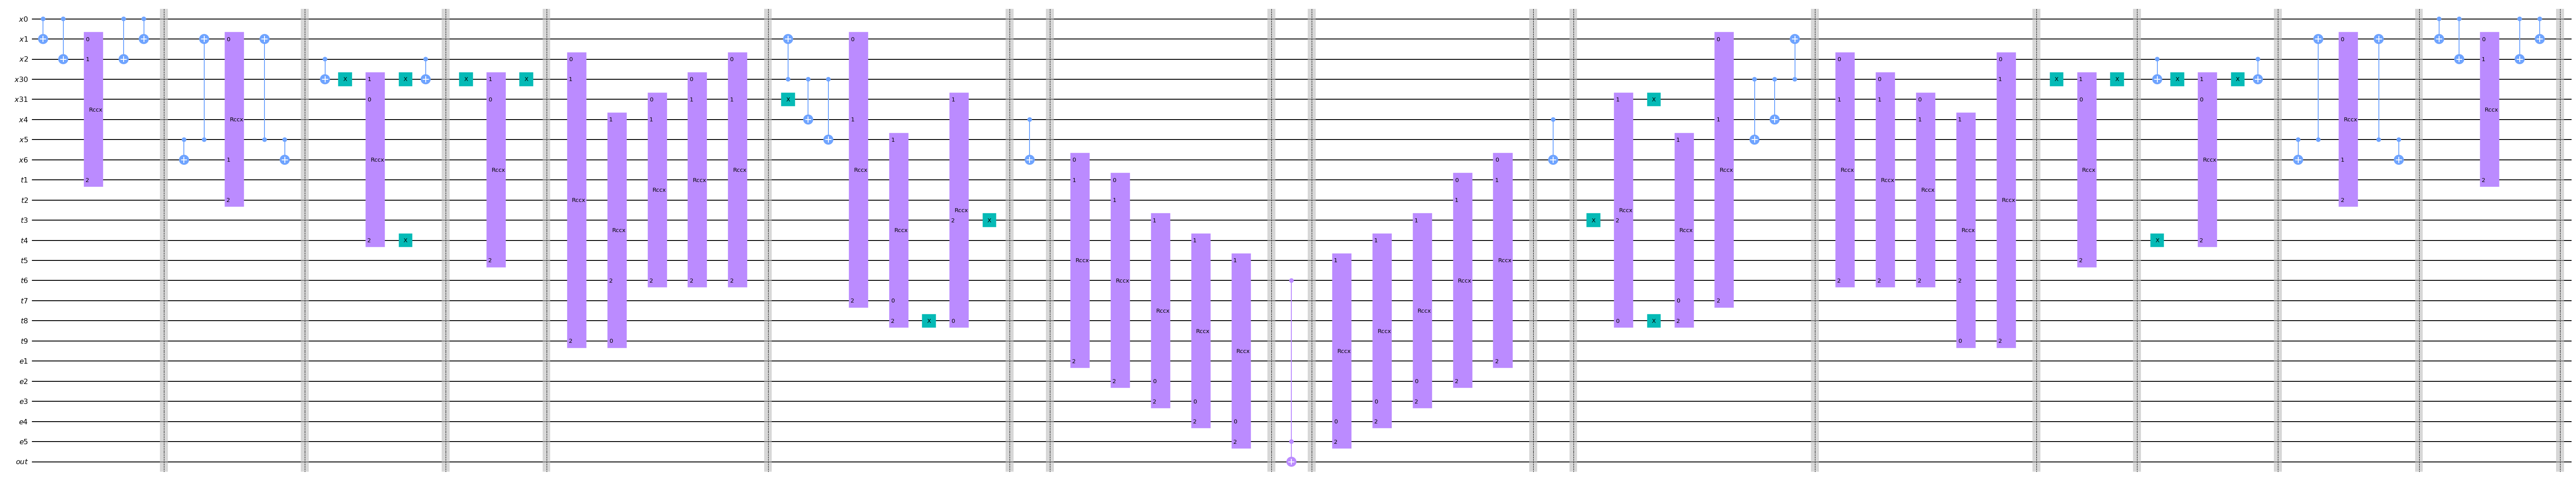

In [388]:
qc = QuantumCircuit(*registers)
add_oracle(qc) 
qc.draw('mpl', fold = -1)

Comments:

- For AND operation we use the simplified Toffoli gate RCCX.

- The implementations of $c12$, $c34$, $c9$, $c10$ are straightforward. We compute them and store the results in qubits $t1$, $t2$, $t5$, $t4$, respectively.

- The implementation of $c11$ consists of 5 RCCX gates. One of them is used instead of AND, the other four instead of (a AND b) XOR c.



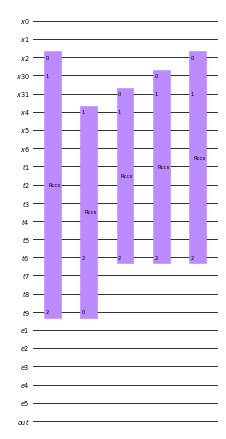

In [367]:
# (𝑥2 ∧ 𝑥31) ⊻ (𝑥31 ∧ 𝑥4) ⊻ (𝑥30 ∧ 𝑥31) ⊻ (𝑥2 ∧ 𝑥30 ∧ 𝑥4)
c11 = QuantumCircuit(*registers)
c11.rccx(x2,x30,t9) 
c11.rccx(t9,x4,t6)  
c11.rccx(x31,x4,t6) 
c11.rccx(x30,x31,t6) 
c11.rccx(x2,x31,t6)

c11.draw('mpl', scale=0.4)

- The implementation of $c678$ uses three addtional qubits $t7$, $t8$, $t3$, the latter contains the resulting value. During the computation the values of $x1$, $x4$, $x5$ are chaneged. These changes are not reverted, since we are near the end of the circuit.

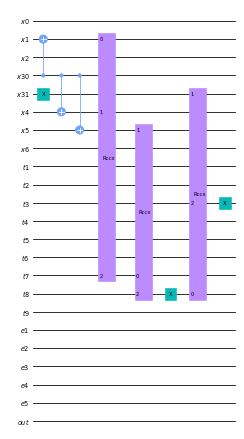

In [371]:
# Or(x31, And(Xor(x1,x30), Xor(x4,x30), Xor(x5,x30)))
c678 = QuantumCircuit(*registers)
c678.cnot(x30, x1)
c678.cnot(x30, x4)
c678.cnot(x30, x5)
c678.rccx(x1, x4, t7)
c678.rccx(t7, x5, t8)
c678.x(t8)
c678.x(x31)
c678.rccx(t8, x31, t3)
c678.x(t3)

c678.draw('mpl', scale=0.4)

- $c5$ is computed stored in $x6$
- Finally, we compute out = AND(x6,t1,t2,t3,t4,t5)

Let us check that the oracle works correctly with the solution:

In [372]:
state = Statevector.from_int(int("10010110", 2), 2**23)
state.draw('latex')

<IPython.core.display.Latex object>

In [373]:
state = state.evolve(qc)
state.draw('latex')

<IPython.core.display.Latex object>

The oracle uses 23 qubits. It contains 28 CNOT, 34 RCCX and 1 TOFFOLI gates. The total cost is

In [417]:
28 + 34*3 + 1*6

136

# Grover’s search

In [409]:
def initialize(ninputs, nregisters):
    reg_bits = ClassicalRegister(ninputs, name = 'c')
    reg_qubits = QuantumRegister(nregisters, name = 'q')
    qc = QuantumCircuit(reg_qubits, reg_bits)
    
    for qubit in range(ninputs):
        qc.h(qubit)
    
    qc.barrier()

    return qc

def create_diffuser(nregisters):
    qc = QuantumCircuit(nregisters)
    
    # H then X
    for qubit in range(nregisters-1):
        qc.h(qubit)
        qc.x(qubit)
    
    # multi-control
    qc.mct(list(range(nregisters-1)), nregisters-1)
    
    # X then H
    for qubit in range(nregisters-1):
        qc.x(qubit)
        qc.h(qubit)
        
    return qc



We have $2^8$ possibilities. Hence we should run 'oracle' $\circ$ 'diffusion' operation $2^4=16$ times.

In [433]:
qc = initialize(8,23)
diff = create_diffuser(9)
diffgate = diff.to_gate()
diffgate.name = "diffuser"

for n in range(16):
    add_oracle(qc)
    qc.append(diffgate, [0,1,2,3,4,5,6,7,22])

qc.measure([0,1,2,3,4,5,6,7], reg_bits)

In [432]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

nshots = 1000
qsim = Aer.get_backend('qasm_simulator')
job = execute(qc, qsim, shots = nshots)
counts = result.get_counts()

IOStream.flush timed out


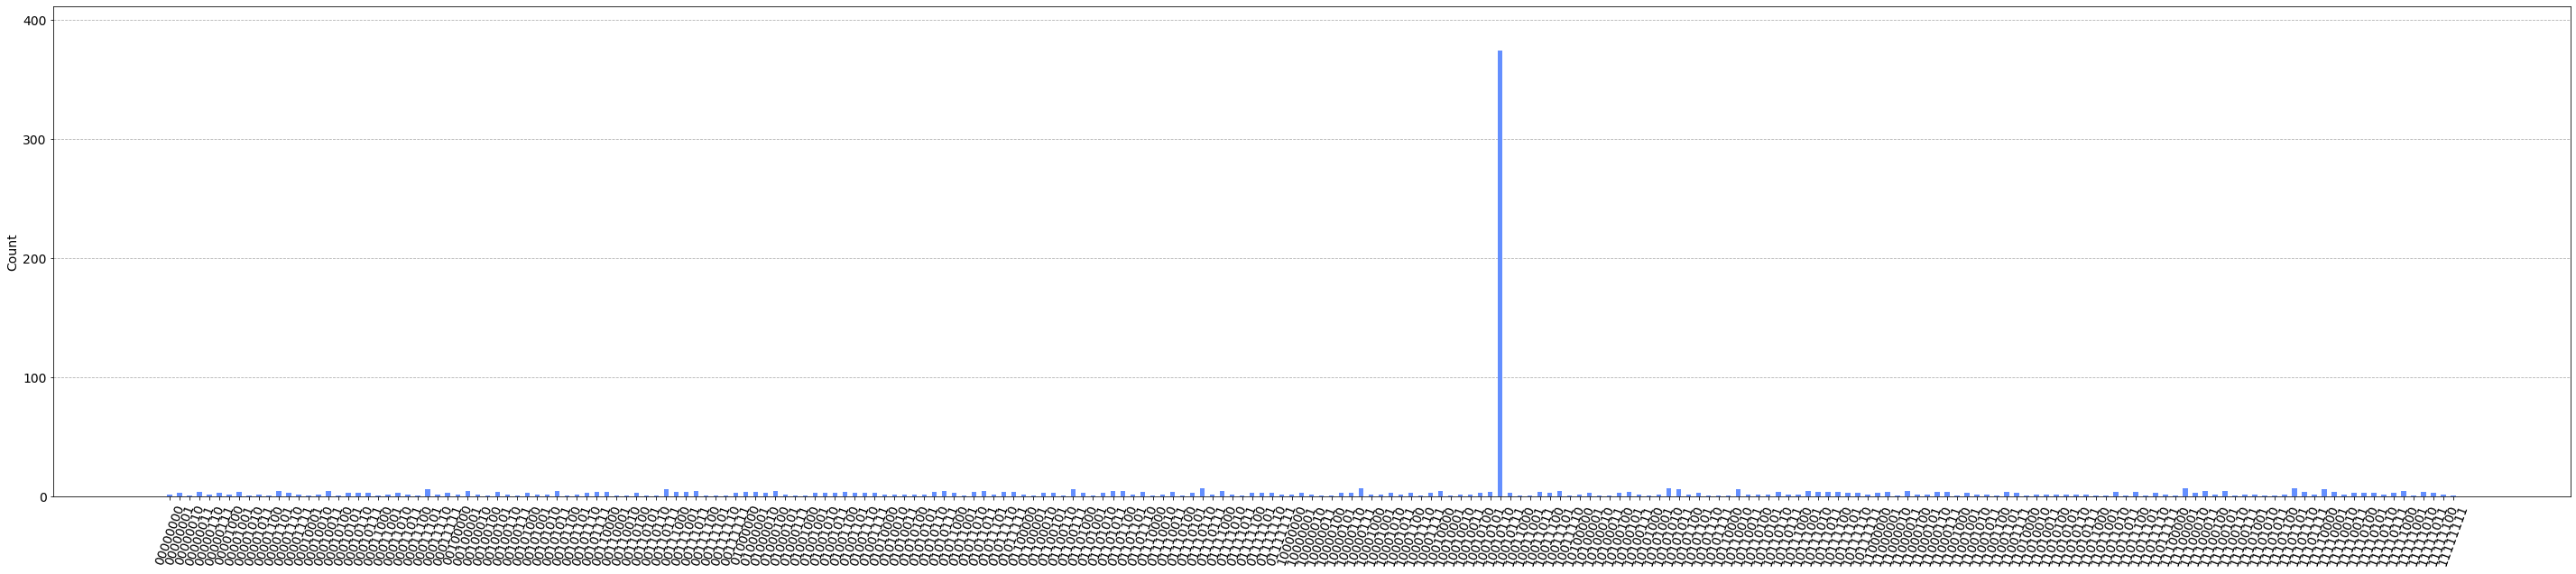

In [451]:
plot_histogram(counts, figsize=(50,10), bar_labels=False)

In [452]:
m = max(counts.values())
[k for k in counts.keys() if counts[k] == m]

['10010110']